###Databricks notebook to run a deep learning CNN model to classify fashion items

This notebook steps through how to implement an image recognition model using a convolutional network. It starts with a basic CNN architecture to classify fashion from the Fashion MNIST data set found here: https://github.com/zalandoresearch/fashion-mnist. The data set consists of images (28*28 in size) in 10 different categories. There are 60,000 images for training and 10,000 images for testing. There are optional steps in the notebook to demonstrate use of more advanced network features. 
    
The model is built using Tensorflow and Keras and assumes you are running on a Databricks cluster and machine learning libraries have been pre-installed. 

This notebook is adapted from work published here:(1) https://github.com/amynic/azureml-sdk-fashion and (2) https://github.com/Microsoft/CNTK/tree/v2.0/Tutorials.

### Import core libraries and specify tensorflow and keras

In [3]:
import tensorflow as tf
import os
import time
os.environ["TF_CPP_MIN_LOG_LEVEL"]= "2"
print("tensorflow Version is: " + str(tf.__version__))

import numpy as np
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras import backend as K
print(os.environ['KERAS_BACKEND'])

tensorflow Version is: 1.12.0
Using TensorFlow backend.
tensorflow

In [4]:
# Import the required Keras functions that will be used to create the CNN
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils, losses, optimizers
import matplotlib.pyplot as plt

### Load the Fashion MNIST data set and visualize an image

The fasion MNIST data set is included with the Keras library so we need to pull it into a training and test datasets. Each image is associated with a label from 1 of 10 classifications: 
  * Label 0: T-shirt/top
  * Label 1: Trouser 
  * Label 2: Pullover 
  * Label 3: Dress 
  * Label 4: Coat 
  * Label 5: Sandal 
  * Label 6: Shirt 
  * Label 7: Sneaker 
  * Label 8: Bag 
  * Label 9: Ankle boot

In [6]:
# Data for training and testing
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(x_train.shape, 'train set')
print(x_test.shape, 'test set')

# Define the text labels
fashion_mnist_labels = ["Top",          # index 0
                        "Trouser",      # index 1
                        "Jumper",       # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Trainer",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9



Downloading data from http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz

 8192/29515 [=======>......................] - ETA: 0s
16384/29515 [===============>..............] - ETA: 0s
32768/29515 [=================================] - 0s 4us/step
Downloading data from http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz

 8192/26421880 [..............................] - ETA: 0s
 16384/26421880 [..............................] - ETA: 3:06
 49152/26421880 [..............................] - ETA: 2:04
 106496/26421880 [..............................] - ETA: 1:25
 229376/26421880 [..............................] - ETA: 52s 
 466944/26421880 [..............................] - ETA: 32s
 950272/26421880 [>.............................] - ETA: 18s
 1908736/26421880 [=>............................] - ETA: 10s
 3833856/26421880 [===>..........................] - ETA: 5s 
 6955008/26421880 [======>.......................] - ETA: 2s
 9994240/26421880 [==========>...................] - ETA: 1s
12632064/26421880 [=============>................] - ETA: 1s
15695872/26421880 [================>.............] - ETA: 0s
18751488/26421880 [====================>.........] - ETA: 0s
21831680/26421880 [=======================>......] - ETA: 0s
24682496/26421880 [===========================>..] - ETA: 0s
26427392/26421880 [==============================] - 2s 0us/step
Downloading data from http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

8192/5148 [===============================================] - 0s 0us/step
Downloading data from http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz

 8192/4422102 [..............................] - ETA: 0s
 16384/4422102 [..............................] - ETA: 31s
 49152/4422102 [..............................] - ETA: 20s
 106496/4422102 [..............................] - ETA: 14s
 229376/4422102 [>.............................] - ETA: 8s 
 466944/4422102 [==>...........................] - ETA: 4s
 950272/4422102 [=====>........................] - ETA: 2s
1908736/4422102 [===========>..................] - ETA: 1s
3358720/4422102 [=====================>........] - ETA: 0s
3833856/4422102 [=========================>....] - ETA: 0s
4423680/4422102 [==============================] - 1s 0us/step
(60000, 28, 28) train set
(10000, 28, 28) test set

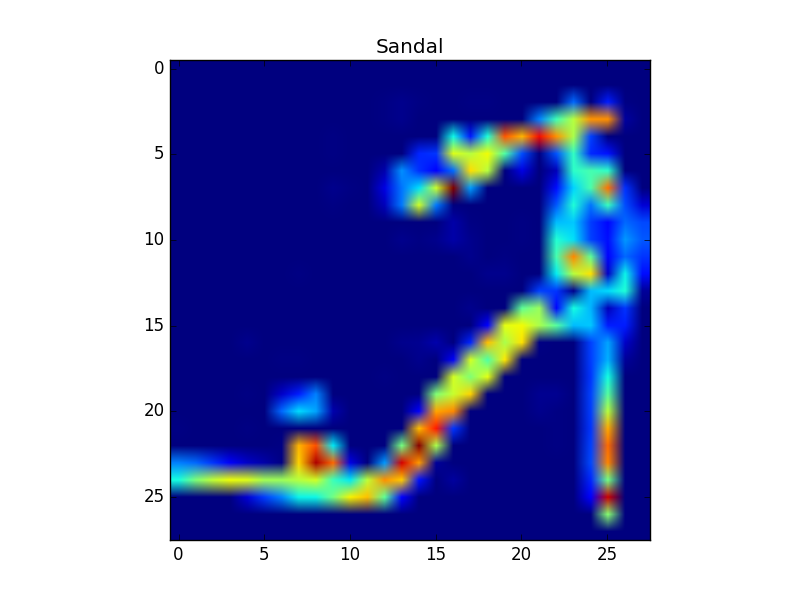

In [7]:
# Visualize an image. To visualize a different image, set the index to any value between 0 and 59999
img_index=8

# Display an image from the data set
label_index = y_train[img_index]
plt.imshow(x_train[img_index])
plt.title(fashion_mnist_labels[label_index])
 
display()

### Normalize and prepare the data

The data set is loaded into memory and will be normalized so the pixel values in each image range between 0-1 instead of 0-255 pixels. This will help the model converge faster because it is working with smaller numbers.

In this section we also one-hot encode the labels for each image. This is done so the model does not treat the label (fashion category) with an implied numeric ranking. For instance, T-Shirts are labeled '0' and Sneakers are labeled '7'. We don't want the model to interpret these values with any numeric ranking. An array will be created and each image will be represented in the array with a '1' corresponding to its label. For instance, an image with an array that looks like this: array([0,0,0,0,0,0,0,0,0,1]) means the image label corresponds to the 9th index which is 'ankle boots'.

In [9]:
# Set number of categories
num_classes = 10

# Set image input dimensions 
img_rows,img_cols = 28,28

# Reshape the array without changing the data.  
# Parameters = number of elements in the input array, the new shape (28*28), and the order 
x_train = x_train.reshape(60000, img_rows, img_cols, 1)
x_test = x_test.reshape(10000, img_rows, img_cols, 1)

# Type convert and scale the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# One-hot encoding of images
# This creates an array equal to the number of labels (fashion categories).  Each image
# is represented in the vector with a 1 corresponding to it's label.  

y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)


Now we are able to define the Convolutional Neural Network (CNN) in layers

![CNN](https://raw.githubusercontent.com/amynic/azureml-sdk-fashion/master/images/cnn.JPG "CNN")

* This is a **sequential model** meaning every layer passes information forward to the next layer of the network
* **1st Convoltuional Layer** - extracts features from data source, these are kernels/filters and feature maps. Feature maps passed to the  next layer. This layer also has a ReLu activation function - Y = max(0, x) this removes any value <0 and prevents vanishing gradients or weights <0
* **2nd pooling layer ** - reduces dimensionality, reduce compute and helps with overfitting of the data.
* **3rd Convolutional Layer ** -we add a Convoltuional Layer - extracts features from data source, these are kernels/filters and feature maps. Feature maps passed to the  next layer. This layer also has a ReLu activation function - Y = max(0, x) this removes any value <0 and prevents vanishing gradients or weights <0
* **4th Pooling Layer ** - reduces dimensionality, reduce compute and helps with overfitting of the data.
* **5th/6th Dense fully connected layer with softmax function:** put features together and classify what item of clothing is used

### Define the CNN network architecture
We will use the sequential API and compile the model with a common algorithm and loss metric.

After running through the experiment, consider coming back to this section and changing some of the parameters, re-run the code, and see how the model and accuracy change.

In [12]:
#First, set some parameters

num_classes = 10

# Sample size that will be processed independently, in parallel
batch_size = 256

#Define the CNN model
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

# Verify model architecture is as expected
model.summary()


_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
conv2d_1 (Conv2D) (None, 26, 26, 64) 640 
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64) 0 
_________________________________________________________________
conv2d_2 (Conv2D) (None, 11, 11, 64) 36928 
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64) 0 
_________________________________________________________________
flatten_1 (Flatten) (None, 1600) 0 
_________________________________________________________________
dense_1 (Dense) (None, 128) 204928 
_________________________________________________________________
dense_2 (Dense) (None, 10) 1290 
=================================================================
Total params: 243,786
Trainable params: 243,786
Non-trainable params: 0
_________________________________________________________________

###Train the model
To train the model, use the fit() method in Keras. This code compiles the CNN model, assigns a common optimizer and loss function and identifies the output metrics to be shown.   
A timer is started to show how long the model takes to run. The test data set is passed in as the validation set so we can see how the accuracy differs between the training set and the validation set.

In [14]:
# Train the model and return loss and accuracy for each epoch

# The number of training passes
epochs = 6

# Batch size is the sample size that will be processed independently, in parallel
batch_size = 256

start = time.time()
hist = model.fit(x_train, y_train, 
                  batch_size=batch_size, 
                  epochs=epochs, verbose=1)
end = time.time()

Epoch 1/6

 256/60000 [..............................] - ETA: 1:49 - loss: 2.3177 - acc: 0.0508
 512/60000 [..............................] - ETA: 1:18 - loss: 2.2942 - acc: 0.1992
 768/60000 [..............................] - ETA: 1:06 - loss: 2.2765 - acc: 0.2643
 1024/60000 [..............................] - ETA: 1:00 - loss: 2.2558 - acc: 0.3096
 1280/60000 [..............................] - ETA: 56s - loss: 2.2299 - acc: 0.3516 
 1536/60000 [..............................] - ETA: 54s - loss: 2.2012 - acc: 0.3919
 1792/60000 [..............................] - ETA: 53s - loss: 2.1696 - acc: 0.4202
 2048/60000 [>.............................] - ETA: 51s - loss: 2.1326 - acc: 0.4370
 2304/60000 [>.............................] - ETA: 50s - loss: 2.0931 - acc: 0.4592
 2560/60000 [>.............................] - ETA: 49s - loss: 2.0488 - acc: 0.4707
 2816/60000 [>.............................] - ETA: 49s - loss: 2.0007 - acc: 0.4801
 3072/60000 [>.............................] - ETA: 48s - loss: 1.9530 - acc: 0.4860
 3328/60000 [>.............................] - ETA: 48s - loss: 1.9051 - acc: 0.4919
 3584/60000 [>.............................] - ETA: 47s - loss: 1.8634 - acc: 0.4936
 3840/60000 [>.............................] - ETA: 47s - loss: 1.8176 - acc: 0.4969
 4096/60000 [=>............................] - ETA: 46s - loss: 1.7708 - acc: 0.5073
 4352/60000 [=>............................] - ETA: 46s - loss: 1.7300 - acc: 0.5142
 4608/60000 [=>............................] - ETA: 46s - loss: 1.6910 - acc: 0.5217
 4864/60000 [=>............................] - ETA: 45s - loss: 1.6524 - acc: 0.5300
 5120/60000 [=>............................] - ETA: 45s - loss: 1.6184 - acc: 0.5332
 5376/60000 [=>............................] - ETA: 44s - loss: 1.5840 - acc: 0.5409
 5632/60000 [=>............................] - ETA: 44s - loss: 1.5530 - acc: 0.5463
 5888/60000 [=>............................] - ETA: 44s - loss: 1.5245 - acc: 0.5520
 6144/60000 [==>...........................] - ETA: 43s - loss: 1.4959 - acc: 0.5586
 6400/60000 [==>...........................] - ETA: 43s - loss: 1.4730 - acc: 0.5631
 6656/60000 [==>...........................] - ETA: 43s - loss: 1.4447 - acc: 0.5712
 6912/60000 [==>...........................] - ETA: 42s - loss: 1.4165 - acc: 0.5773
 7168/60000 [==>...........................] - ETA: 42s - loss: 1.3949 - acc: 0.5822
 7424/60000 [==>...........................] - ETA: 42s - loss: 1.3744 - acc: 0.5858
 7680/60000 [==>...........................] - ETA: 42s - loss: 1.3531 - acc: 0.5906
 7936/60000 [==>...........................] - ETA: 41s - loss: 1.3334 - acc: 0.5946
 8192/60000 [===>..........................] - ETA: 41s - loss: 1.3133 - acc: 0.5980
 8448/60000 [===>..........................] - ETA: 41s - loss: 1.2939 - acc: 0.6039
 8704/60000 [===>..........................] - ETA: 41s - loss: 1.2774 - acc: 0.6072
 8960/60000 [===>..........................] - ETA: 41s - loss: 1.2633 - acc: 0.6100
 9216/60000 [===>..........................] - ETA: 41s - loss: 1.2447 - acc: 0.6145
 9472/60000 [===>..........................] - ETA: 40s - loss: 1.2286 - acc: 0.6183
 9728/60000 [===>..........................] - ETA: 40s - loss: 1.2146 - acc: 0.6203
 9984/60000 [===>..........................] - ETA: 40s - loss: 1.2004 - acc: 0.6239
10240/60000 [====>.........................] - ETA: 40s - loss: 1.1880 - acc: 0.6265
10496/60000 [====>.........................] - ETA: 39s - loss: 1.1781 - acc: 0.6283
10752/60000 [====>.........................] - ETA: 39s - loss: 1.1698 - acc: 0.6297
11008/60000 [====>.........................] - ETA: 39s - loss: 1.1583 - acc: 0.6321
11264/60000 [====>.........................] - ETA: 39s - loss: 1.1463 - acc: 0.6350
11520/60000 [====>.........................] - ETA: 39s - loss: 1.1374 - acc: 0.6361
11776/60000 [====>.........................] - ETA: 38s - loss: 1.1262 - acc: 0.6390
12032/60000 [=====>........................] - ETA: 38s - loss: 1.1163 - acc:

In [15]:
# Print how long it took to train the  model
print('Time to train model (sec): ', (end-start))

Time to train model (sec): 273.19585371017456

### Score the model

In [17]:
# Evaluate the model on the test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])

Test Loss: 0.29349746990203857
Test Accuracy: 0.8903

###Plot model evaluation metrics

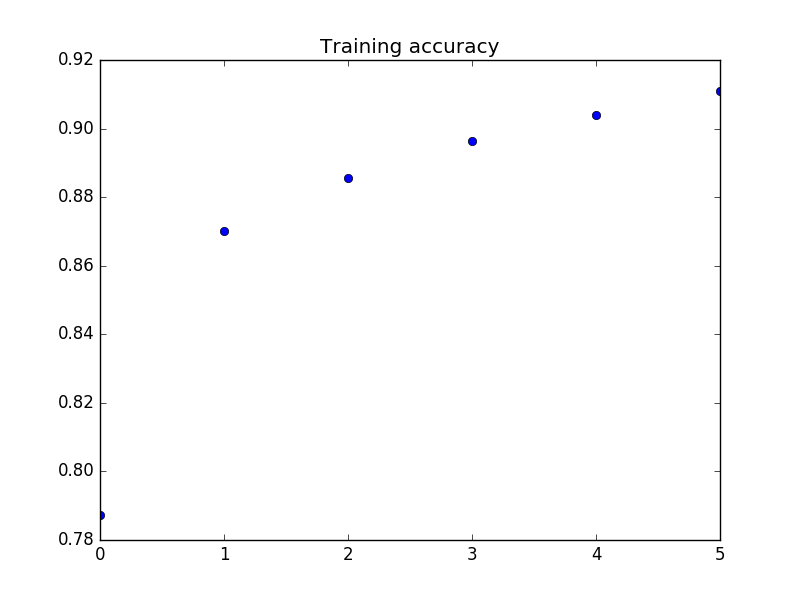

In [19]:
# Plot model accuracy across the epochs 

accuracy = hist.history['acc']

epochs = range(len(accuracy))

fig = plt.figure()
plt.plot(epochs, accuracy, 'bo')
plt.title('Training accuracy')
plt.legend()

display(fig)

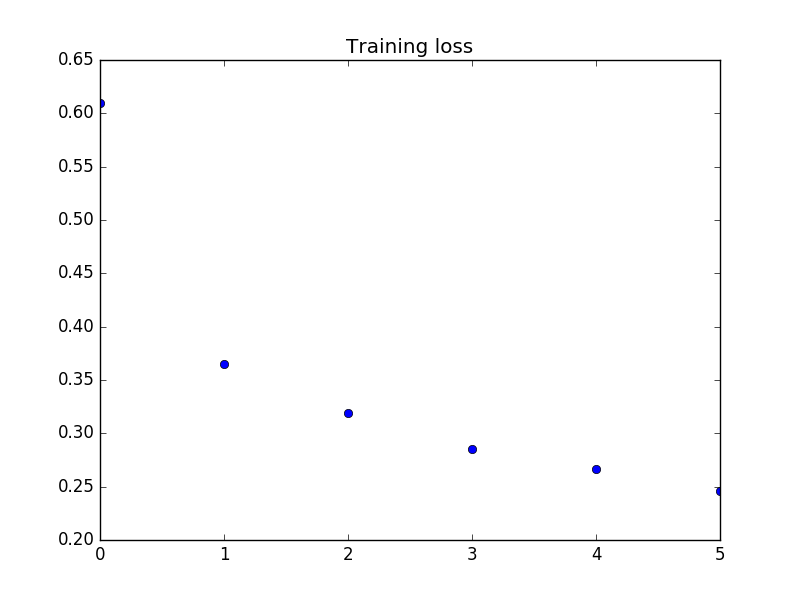

In [20]:
# Plot model loss across the epochs

loss = hist.history['loss']

fig = plt.figure()
plt.plot(epochs, loss, 'bo')
plt.title('Training loss')
plt.legend()

display(fig)

### Predict labels for 15 images from test set

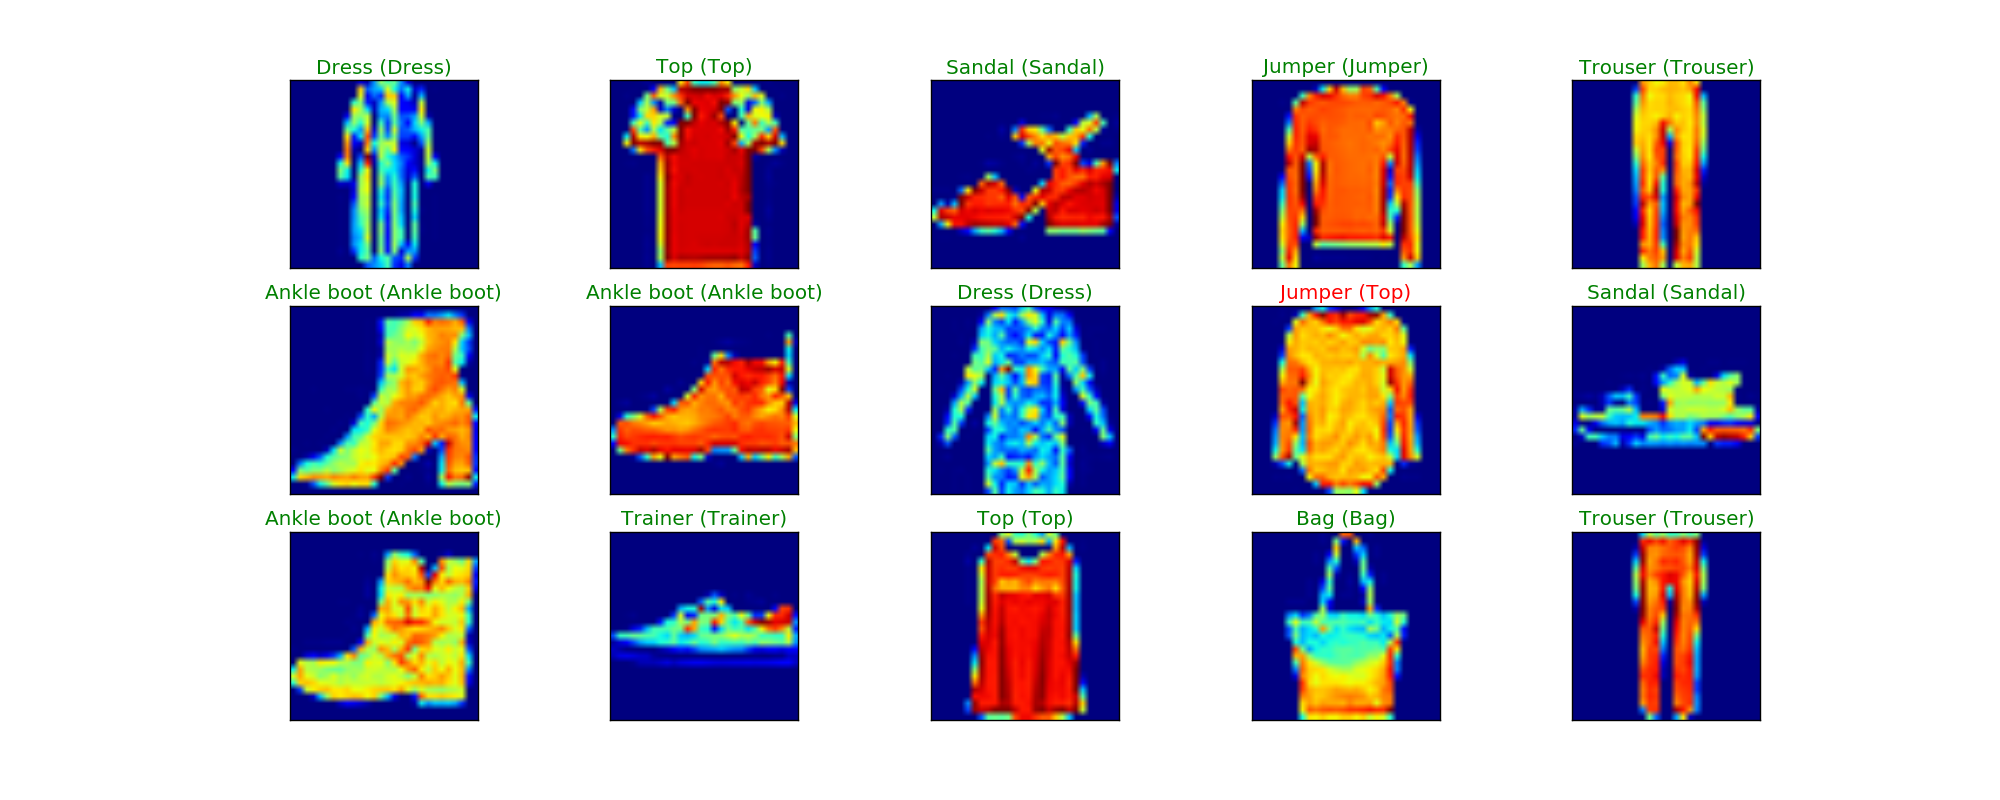

In [22]:
# Run this code to see if the labels for each of 15 images was predicted correctly
predictions = model.predict(x_test)

# Plot a random sample of 15 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(predictions[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
# Visualize in databricks
display()

###Show the impact of changing the activation function

To easily see the impact of changing the activation function, a python function is defined below to construct, compile, train, and score a model.

In [24]:
def runCNN(activation, verbose):

  img_rows, img_cols = 28, 28
  input_shape = (img_rows, img_cols, 1)
  epochs = 1

  # Build the CNN
  model = Sequential()
  
  # Convolution Layer
  model.add(Conv2D(64, kernel_size=(3, 3),
                 activation=activation,
                 input_shape = (28,28,1))) 
  
  # Pooling with stride (2, 2)
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Flatten layer
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))

   # Randomly delete 50% of neurons to avoid overfitting  
  model.add(Dropout(0.5))
  
   # Apply softmax
  model.add(Dense(num_classes, activation='softmax'))
 
  # Loss function (crossentropy) and Optimizer (Adam)
  model.compile(loss = losses.categorical_crossentropy,
              optimizer = optimizers.Adam(),
              metrics=['accuracy'])
 
  # Train model
  model.fit(x_train, y_train, 
                batch_size=batch_size, 
                epochs=epochs, verbose=0)

  # Evaluate model
  score = model.evaluate(x_test, y_test, verbose=0)
  
  # Return
  return score

In [25]:
# Sigmoid activation  

score_sigmoid = runCNN('sigmoid', 0)
print('Sigmoid, Test loss:', score_sigmoid[0])
print('Sigmoid, Test accuracy:', score_sigmoid[1])


Sigmoid, Test loss: 0.777042947435379
Sigmoid, Test accuracy: 0.7104

In [26]:
# Tanh activation

score_tanh = runCNN('tanh', 0)
print('tanh, Test loss:', score_tanh[0])
print('tanh, Test accuracy:', score_tanh[1])


tanh, Test loss: 0.43607300066947935
tanh, Test accuracy: 0.8408

In [27]:
# Relu activation

score_sigmoid = runCNN('sigmoid', 0)
print('Sigmoid, Test loss:', score_sigmoid[0])
print('Sigmoid, Test accuracy:', score_sigmoid[1])


Sigmoid, Test loss: 2.3025934589385986
Sigmoid, Test accuracy: 0.1